# $$\textbf{Quantum Kitchen Sinks}$$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

from pyquil import get_qc, Program

from qks_utils import generate_frame

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Consider the following "picture frames" dataset.

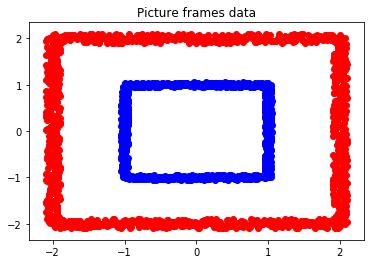

In [2]:
num_datapts = 1000
x_small, y_small = generate_frame(num_datapts, 2, 0.1)
x_big, y_big = generate_frame(num_datapts, 4, 0.2)
plt.scatter(x_small, y_small, color='blue')
plt.scatter(x_big, y_big, color='red')
plt.title("Picture frames data")
plt.show()

No linear classifier, such as Logistic Regression, would be able to accurately classify the data above. This can be readily seen from the exercise below.

In [3]:
# generate the label '1' for the small (blue) picture frame,
#      and the label '0' for the large (red) picture frame
small_frame = np.column_stack([x_small, y_small, np.ones(num_datapts)])
big_frame = np.column_stack([x_big, y_big, np.zeros(num_datapts)])
picture_frames = np.row_stack([small_frame, big_frame])

# split into training and testing sets
feat_train, feat_test, label_train, label_test = train_test_split(
            picture_frames[:, :2], picture_frames[:, 2], test_size=0.20)

# fit a Logistic Regression model onto this data
model = LogisticRegression(solver='lbfgs')
model.fit(feat_train, label_train)
label_preds = model.predict(feat_test)

# report the accuracy score obtained (on a scale of 0.0 - 1.0)
# (see https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score)
accuracy = accuracy_score(label_test, label_preds)
print(f"Accuracy: {accuracy}")

Accuracy: 0.555


So we get the answer right only about half of the time. Which is to be expected, since no matter what kind of line you draw as a decision boundary on the figure above, the best you'd be able to do is to classify about half of the datapoints correctly, while misclassifying the remaining half.

Enter **Quantum Kitchen Sinks**. Based on the ideas introduced in https://arxiv.org/abs/1806.08321, let us imagine that every data point $u_i = (x_i, y_i)$ in the "picture frames" dataset gets mapped to some parameters of a quantum circuit,<br>
<br>
$$ \Phi\, : u_i \rightarrow \theta_i$$
<br>
where the $\theta_i$ could be e.g. the rotation angles of an $RX$ gate on some qubit.
Furthermore, the map $\Phi$ could depend on some random parameters $\Omega$ and $\beta$. To use a specific example, let us take<br>
<br>
$$\Omega = \begin{pmatrix} \alpha_0 & 0 \\ 0 & \alpha_1 \end{pmatrix}$$
<br>
where each of the diagonal entries are drawn i.i.d. from the standard normal distribution $\mathcal{N}(0, 1)$. Let us also draw $\beta$ from the uniform distribution on the interval $[0, 2 \pi]$, and transform each 2-dimensional datapoint $u_i$ into a 2-dimensional parameter $\theta_i$ as<br>
<br>
$$\theta_i = \Omega \cdot u_i + \beta$$
<br>
In fact, for every data point $u_i$, let us calculate $E$ different $\theta_i$'s for just as many different values of $\Omega$ and $\beta$, where $E$ prescribes the total no. of "episodes". We'll use the index $e$ to specify the various episodes, we modify the expression above to the more precise<br>
<br>
$$\theta_{ie} = \Omega_e \cdot u_i + \beta_e$$
<br>
Before we go any further, let's first create a function that draws all the random variables we need. We'll do this for an ansatz(an educated guess) where we need two rotation angles for rotations on two separate qubits, an ansatz we'll refer to as the "2q ansatz" for short. It is important that we draw the same set of random parameters for all the data points in a data set. (Notice how the datapoints $u_i$ do not carry the index $e$!)

In [4]:
def random_parameters_2q_ansatz(dim_input=2, num_episodes=500):
    """
    Returns two sets of random parameters:-

    alphas: entries drawn from the standard normal distribution N(0,1)
        with shape (dim_input, num_episodes)
    betas: entries drawn the uniform distribution U[0,2*pi]
        with shape (num_episodes, 2), since we have a 2q ansatz
    """
    # draw the diagonal entries of Ω matrix, a 2x2 matrix for each episode
    alphas = np.random.normal(0.0, 1.0, size=dim_input * num_episodes)
    # draw the β's, a 2-dimensional vector for each episode
    betas = np.random.uniform(low=0.0, high=2 * np.pi, size=dim_input * num_episodes).reshape(-1, 2) 

    return alphas, betas

Next, we will use these features to transform the squares of the "picture frames" dataset into the parameters $\theta_{ie}$. We will further use these features as rotation angles in a quantum circuit using the ansatz shown below (generated using `pyquil.latex`).

<img src="qks_2q_ansatz.png" alt="Drawing" style="width: 200px;"/>

In [5]:
def circuit_qc_2q():
    """
    Circuit for the 2-qubit ansatz

    :return: pyQuil Program corresponding to the 2-qubit ansatz
    """
    program = Program("""
DECLARE theta0 REAL
DECLARE theta1 REAL
DECLARE ro BIT[2]

RX(theta0) 0
RX(theta1) 1
CNOT 0 1

MEASURE 0 ro[0]
MEASURE 1 ro[1]
""")
    return program

Notice that we kept our circuit ansatz purely parameteric, i.e. we didn't specify values for either parameter `theta0` or `theta1`. Because of pyQuil's ability to perform parametric compilation, this saves us some overhead in running the ansatz above over a range of values for the parameters.

Next, we write a helper function that will transform a datapoint into a set of rotation angles. As discussed earlier, this transformation is described as<br>
<br>
$$\theta_{ie} = \Omega_e \cdot u_i + \beta_e$$
<br>

In [6]:
def rotation_angles_2q_ansatz(i, e, data, alphas, betas):
    """
    Identify the 2 random rotation angles in a current loop, to feed into quantum circuit

    :param int i: index specifying datapoint
    :param int e: index specifying episode
    :param array alphas: pre-generated array containing random parameters for the linear transformation
    :param array betas: pre-generated array containing random parameters for the bias vector
    :param array data: input data with shape (n, m) where n = no. of datapoints, and each datapoint is an m-dimensional
        column vector
    :return: 2-dimensional array containing the random rotation angles (numpy array)
    """
    # identify the dimension of the feature space
    dim = data.shape[1]
    # structure the linear transformation matrix omega_e according to a 2-qubit ansatz (block diagonal format)
    en = dim * e
    omega_e = np.block(
        [[alphas[en:en + dim // 2], np.zeros(dim // 2)], [np.zeros(dim // 2), alphas[en + dim // 2:en + dim]]])
    # obtain the bias vector
    beta_e = betas[e]
    # perform random affine transformation on datapoint to obtain rotation angles
    theta_ie = omega_e.dot(data[i]) + beta_e
    return theta_ie

Once we have the rotation angles, we can use it in the circuit of the 2q ansatz. For every datapoint, we run the circuit for several shots, concatenating the bit-strings we sample into a single feature vector. This entire procedure has now transformed each of our original 2-dimensional datapoints into a high-dimensional vector composed of the bit-characters `0` and `1`. Those feature vectors can later be used in a run-of-the-mill (classical) machine learning classifier.

To complete this procedure, we'll write a function that takes as input a quantum resource, and a dataset, and transforms the entire dataset into the binary vectors described above.

In [7]:
def featurize_data_2q_ansatz(qc, data, num_episodes=500):
    """
    Convert input dataset into a set of binary vectors according to the 2-qubit ansatz;
    Draws all random parameters once, and uses them for each datapoint

    :param array data: input data with shape (n, m) where n = no. of datapoints, and each datapoint
        is an m-dimensional column vector
    :param int num_episodes: number of episodes per data point
    :return: a high-dimensional random featurized dataset with shape (n, 2 * num_episodes), where
        n = no. of datapoints in input data (numpy array)
    """
    assert len(data.shape) == 2
    # sample the random elements to use across all datapoints
    alphas, betas = random_parameters_2q_ansatz(dim_input=data.shape[1], num_episodes=num_episodes)
    # create and compile parametric circuit for the 2q ansatz
    prog = circuit_qc_2q()
    nq_prog = qc.compiler.quil_to_native_quil(prog)
    executable = qc.compiler.native_quil_to_executable(nq_prog)
    # initialize empty list to hold 'random' features for each datapoint
    r_feats = []
    for i in range(data.shape[0]):
        print(f"\rWorking on datapoint {i+1} / {data.shape[0]}", end="")
        sys.stdout.flush()
        # create random features for current datapoint
        r_feat = []
        for e in range(num_episodes):
            # identify the rotation angles
            theta_ie = rotation_angles_2q_ansatz(i, e, data, alphas, betas)
            # collect result for current value of rotation angles
            result = qc.run(executable, memory_map={'theta0': [theta_ie[0]], 'theta1': [theta_ie[1]]})
            r_feat += list(result)
        # collect together the random features for each datapoint
        r_feats.append(r_feat)

    return np.array(r_feats).reshape(data.shape[0], -1)

We'll use this to featurize all the datapoints in the "picture frames" dataset (NOTE: the labels are not part of the input to the function we wrote above).

In [ ]:
qc = get_qc('2q-qvm')
qks_feats = featurize_data_2q_ansatz(qc, picture_frames[:, :2], num_episodes=10)


Working on datapoint 46 / 2000

Having created the randomized features using the quantum kitchen sinks procedure (the "qks features" for short), we can now perform another train/test split of the picture frames dataset using these new set of features along with the original labels.

In [ ]:
# split into training and testing sets
feat_train, feat_test, label_train, label_test = train_test_split(
            qks_feats, picture_frames[:, 2], test_size=0.20)

We can now fit a vanilla linear classifier, such as Logistic Regression, to our qks features and see how it performs.

In [ ]:
# fit a Logistic Regression model onto this data
model = LogisticRegression(solver='lbfgs')
model.fit(feat_train, label_train)
label_preds = model.predict(feat_test)

# report the accuracy score obtained (on a scale of 0.0 - 1.0)
# (see https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score)
accuracy = accuracy_score(label_test, label_preds)
print(f"Accuracy: {accuracy}")

We observe a higher accuracy score using the qks features than we did with the original features! Transforming to this high-dimensional binary vector space makes it easier for linear classifiers to classify the original dataset. Try increasing the `num_episodes` input, and see if you get even higher accuracy.